In [1]:
import os
import numpy as np
import scipy as sp
import robot_data_treatment

## RoboCin Dataset

Below is a diagram of a roboCin SSL robot, where 4 wheels with their respective speeds ($[\omega_1,\omega_2,\omega_3,\omega_4]$) move the robot in order to create velocities $[v_x, v_y, \omega]$.

![robot dinamics](../imgs/robot_model2.png)

The wheel velocities can be translated into robot velocities using the following matrix transformation:

$$
    C = (1/r)\begin{bmatrix}
    -\sin{\theta_1} & \cos{\theta_1} & l \\
    -\sin{\theta_2} & \cos{\theta_2} & l \\
    -\sin{\theta_3} & \cos{\theta_3} & l \\
    -\sin{\theta_4} & \cos{\theta_4} & l \\
\end{bmatrix} 
$$

$$
\begin{bmatrix}
    v_x\\
    v_y\\
    \omega\\
\end{bmatrix} = C \begin{bmatrix}
    \omega_1\\
    \omega_2\\
    \omega_3\\
    \omega_4\\
\end{bmatrix}
$$

For our robot, $\theta_1 = \pi/3,\ \theta_2 = \pi-\pi/4,\ \theta_3 = \pi + \pi/4,\ \theta_4 = 2\pi-\pi/3,\ r = 0.025m,\ l = 0.083m $, where the $\theta$'s are the angles of each wheel relative to x-axis, $r$ is the radius of each wheel and $l$ is the distance between the wheels and the center of the robot.

A dataset was collected of different robots performing squared trajectories and logging a ground-truth pose (x, y, and angle coordinates) from an overhead camera, wheel speeds and timestamps of each measurement. A snippet of the collected data can be seen below.

As this is a transformation from 4 dimensions to 3 dimensions, the imprecision of each dimensions in the "wheel frame" is combined when translated to "robot frame". This model doesn't allow accurate tracking of the position of the robot in global frame of reference. Our goal is to verify if a data-driven approach can properly model the system dynamics in a way that a model-based estimation can't, as these errors are coming mostly from our poor definition of the model, so adding processes noises on a Kalman Filter (or the extended version) doesn't perform as well as intended.



In [47]:
basePath = '../data/'
csvPaths = ['quadrado_opt_1_1.csv', 'quadrado_opt_1_2.csv', 'quadrado_opt_1_3.csv', 'quadrado_opt_1_4.csv',
            'quadrado_opt_1_5.csv','quadrado_opt_2_1.csv','quadrado_opt_2_2.csv','quadrado_opt_2_3.csv',
            'quadrado_opt_2_4.csv','quadrado_opt_2_5.csv']
paths = []
for csvPath in csvPaths:
    paths.append(basePath+csvPath)

sequenceLength = 50

data, targets, data0, cv_data, cv_target = robot_data_treatment.dataGet_v2(paths, sequenceLength)

trainTuple = []
valTuple = []

for iter in range(len(data)):
    trainTuple.append((data[iter], targets[iter]))

for iter in range(len(cv_data)):
    valTuple.append((cv_data[iter], cv_target[iter]))

## GRU Model

The model was kept close to [Kaggle's example](https://www.kaggle.com/code/fareselmenshawii/gru-from-scratch) but with changes in relation to input/output dimensions, how the backpropagation and loss were calculated.

### inputs and outputs

Input of the model is now a sequence of the following vector:

$$
x_k = \begin{bmatrix}
    \omega_1\\
    \omega_2\\
    \omega_3\\
    \omega_4\\
    \theta\\
\end{bmatrix}_k
$$

While the output has the following format:
$$
y_k = 
\begin{bmatrix}
    v_x \\
    v_y \\
    \omega \\
\end{bmatrix}_k
$$

$y_k$ are the velocities in relation to a global reference frame, so the $\theta$ angle was added to the input vector as an expectation the system would learn to also perform the rotation matrix. $\theta$ is taken from the vision system, but the assumption here is that if we can provide the angle, can the robot have its own physical system modelled properly?

The sequence given to the model is a sequence of 10 timestamps, alongside their groundtruths.

### loss function and backpropagation

The new loss function can be defined as follows:

$$
L = \sum\limits_{i=0}^{N-1}{(\frac{1}{(N-i)}(\tilde{y}_i - gt_i)^2)}
$$

$$
Loss = L[0] + L[1] + L[2]
$$

This way, we weigh more the end of the sequence than the beginning. But also give equal importance to all three elements of the output vector

Consequently, the backpropagation is now:

$$

\frac{\partial{L}}{\partial{y_i}}_t = \frac{1}{(N-t)}(\tilde{y}_i - gt_{t,i})
$$


In [48]:
class GRU_robot:
    """
    A class used to represent a Recurrent Neural Network (GRU).

    Attributes
    ----------
    hidden_size : int
        The number of hidden units in the GR.
    vocab_size : int
        The size of the vocabulary used by the GRU.
    sequence_length : int
        The length of the input sequences fed to the GRU.
    self.learning_rate : float
        The learning rate used during training.

    Methods
    -------
    __init__(hidden_size, vocab_size, sequence_length, self.learning_rate)
        Initializes an instance of the GRU class.
    """

    def __init__(self, trainSet, valSet, hidden_size, sequence_length, learning_rate):
        """
        Initializes an instance of the GRU class.

        Parameters
        ----------
        hidden_size : int
            The number of hidden units in the GRU.
        vocab_size : int
            The size of the vocabulary used by the GRU.
        sequence_length : int
            The length of the input sequences fed to the GRU.
        learning_rate : float
            The learning rate used during training.
        """
        self.hidden_size = hidden_size
        self.trainSet = trainSet
        self.valSet = valSet

        self.output_size = 3
        self.input_size = 5

        # hyper parameters
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate


        # model parameters
        self.Wz = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size),
                                    (hidden_size, hidden_size + self.input_size))
        self.bz = np.zeros((hidden_size, 1))

        self.Wr = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size),
                                    (hidden_size, hidden_size + self.input_size))
        self.br = np.zeros((hidden_size, 1))

        self.Wa = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size),
                                    (hidden_size, hidden_size + self.input_size))
        self.ba = np.zeros((hidden_size, 1))

        self.Wy = np.random.uniform(-np.sqrt(1. / hidden_size), np.sqrt(1. / hidden_size),
                                    (self.output_size, hidden_size))
        self.by = np.zeros((self.output_size, 1))

        # initialize gradients for each parameter
        self.dWz, self.dWr, self.dWa, self.dWy = np.zeros_like(self.Wz), np.zeros_like(self.Wr), np.zeros_like(
            self.Wa), np.zeros_like(self.Wy)
        self.dbz, self.dbr, self.dba, self.dby = np.zeros_like(self.bz), np.zeros_like(self.br), np.zeros_like(
            self.bz), np.zeros_like(self.by)

        # initialize parameters for adamw optimizer
        self.mWz = np.zeros_like(self.Wz)
        self.vWz = np.zeros_like(self.Wz)
        self.mWr = np.zeros_like(self.Wr)
        self.vWr = np.zeros_like(self.Wr)
        self.mWa = np.zeros_like(self.Wa)
        self.vWa = np.zeros_like(self.Wa)
        self.mWy = np.zeros_like(self.Wy)
        self.vWy = np.zeros_like(self.Wy)
        self.mbz = np.zeros_like(self.bz)
        self.vbz = np.zeros_like(self.bz)
        self.mbr = np.zeros_like(self.br)
        self.vbr = np.zeros_like(self.br)
        self.mba = np.zeros_like(self.ba)
        self.vba = np.zeros_like(self.ba)
        self.mby = np.zeros_like(self.by)
        self.vby = np.zeros_like(self.by)

    def sigmoid(self, x):
        """
        Computes the sigmoid activation function for a given input array.

        Parameters:
            x (ndarray): Input array.

        Returns:
            ndarray: Array of the same shape as `x`, containing the sigmoid activation values.
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Computes the softmax activation function for a given input array.

        Parameters:
            x (ndarray): Input array.

        Returns:
            ndarray: Array of the same shape as `x`, containing the softmax activation values.
        """
        # shift the input to prevent overflow when computing the exponentials
        x = x - np.max(x)
        # compute the exponentials of the shifted input
        p = np.exp(x)
        # normalize the exponentials by dividing by their sum
        return p / np.sum(p)

    def forward(self, X, c_prev, a_prev):
        """
        Performs forward propagation for a simple GRU model.

        Args:
            X (numpy array): Input sequence, shape (sequence_length, input_size)
            c_prev (numpy array): Previous cell state, shape (hidden_size, 1)
            a_prev (numpy array): Previous hidden state, shape (hidden_size, 1)

        Returns: X (numpy array): Input sequence, shape (sequence_length, input_size) c (dictionary): Cell state for
        each time step, keys = time step, values = numpy array shape (hidden_size, 1) r (dictionary): Reset gate for
        each time step, keys = time step, values = numpy array shape (hidden_size, 1) z (dictionary): Update gate for
        each time step, keys = time step, values = numpy array shape (hidden_size, 1) cc (dictionary): Candidate cell
        state for each time step, keys = time step, values = numpy array shape (hidden_size, 1) a (dictionary):
        Hidden state for each time step, keys = time step, values = numpy array shape (hidden_size, 1) y_pred (
        dictionary): Output probability vector for each time step, keys = time step, values = numpy array shape (
        output_size, 1)
        """

        # initialize dictionaries for backpropagation
        # initialize dictionaries for backpropagation
        r, z, c, cc, a, y_pred = {}, {}, {}, {}, {}, {}
        c[-1] = np.copy(c_prev)  # store the initial cell state in the dictionary
        a[-1] = np.copy(a_prev)  # store the initial hidden state in the dictionary

        # iterate over each time step in the input sequence
        for t in range(X.shape[0]):
            # concatenate the input and hidden state
            xt = X[t, :].reshape(-1, 1)
            #print("xt", xt)
            concat = np.vstack((a[t - 1], xt))
            #print("concat=", concat)
            # compute the reset gate
            r[t] = self.sigmoid(np.dot(self.Wr, concat) + self.br)

            # compute the update gate
            z[t] = self.sigmoid(np.dot(self.Wz, concat) + self.bz)

            # compute the candidate cell state
            cc[t] = np.tanh(np.dot(self.Wa, np.vstack((r[t] * a[t - 1], xt))) + self.ba)

            # compute the cell state
            c[t] = z[t] * cc[t] + (1 - z[t]) * c[t - 1]

            # compute the hidden state
            a[t] = c[t]
            # compute the output probability vector
            #y_pred[t] = self.softmax(np.dot(self.Wy, a[t]) + self.by)
            y_pred[t] = np.dot(self.Wy, a[t]) + self.by
        # return the output probability vectors, cell state, hidden state and gate vectors
        return X, r, z, c, cc, a, y_pred

    def backward(self, X, a_prev, c_prev, r, z, c, cc, a, y_pred, targets):
        """
        Performs backward propagation through time for a GRU network.

        Args:
            X (numpy array): Input sequence, shape (sequence_length, input_size)
            a_prev (numpy array): Previous hidden state, shape (hidden_size, 1)
            r (dictionary): Reset gate for each time step, keys = time step, values = numpy array shape (hidden_size, 1)
            z (dictionary): Update gate for each time step, keys = time step, values = numpy array shape (hidden_size, 1)
            c (dictionary): Cell state for each time step, keys = time step, values = numpy array shape (hidden_size, 1)
            cc (dictionary): Candidate cell state for each time step, keys = time step, values = numpy array shape (hidden_size, 1)
            a (dictionary): Hidden state for each time step, keys = time step, values = numpy array shape (hidden_size, 1)
            y_pred (dictionary): Output probability vector for each time step, keys = time step, values = numpy array shape (output_size, 1)
            targets (numpy array): Target outputs for each time step, shape (sequence_length, output_size)

        Returns:
            None
        """
        # Initialize gradients for hidden state
        dc_next = np.zeros_like(c_prev)
        da_next = np.zeros_like(a_prev)

        # Iterate backwards through time steps
        for t in reversed(range(X.shape[0])):
            # compute the gradient of the output probability vector
            dy = np.copy(y_pred[t])
            for index in range(len(dy)):
                div = self.sequence_length
                dy[index] = (2.0/(div))*(dy[index] - targets[t][index])
            #dy[targets[t]] -= 1

            # compute the gradient of the output layer weights and biases
            self.dWy += np.dot(dy, a[t].T)
            self.dby += dy

            # compute the gradient of the hidden state
            da = np.dot(self.Wy.T, dy) + da_next

            # compute the gradient of the update gate
            xt = X[t, :].reshape(-1, 1)
            concat = np.vstack((a_prev, xt))
            dz = da * (a[t] - c[t])
            self.dWz += np.dot(dz, concat.T)
            self.dbz += dz

            # compute the gradient of the reset gate
            dr = da * np.dot(self.Wz[:, :self.hidden_size].T, dz) * (1 - r[t]) * r[t]
            self.dWr += np.dot(dr, concat.T)
            self.dbr += dr

            # compute the gradient of the current hidden state
            da = np.dot(self.Wa[:, :self.hidden_size].T, dr) + np.dot(self.Wz[:, :self.hidden_size].T, dz)
            self.dWa += np.dot(da * (1 - a[t]**2), concat.T)
            self.dba += da * (1 - a[t]**2)

            # compute the gradient of the input to the next hidden state
            da_next = np.dot(self.Wr[:, :self.hidden_size].T, dr) \
                      + np.dot(self.Wz[:, :self.hidden_size].T, dz) \
                      + np.dot(self.Wa[:, :self.hidden_size].T, da)
        # clip gradients to avoid exploding gradients
        for grad in [self.dWz, self.dWr, self.dWa, self.dWy, self.dbz, self.dbr, self.dba, self.dby]:
            np.clip(grad, -1, 1)

    def loss(self, y_preds, targets):
        """
        Computes the cross-entropy loss for a given sequence of predicted probabilities and true targets.

        Parameters:
            y_preds (ndarray): Array of shape (sequence_length, vocab_size) containing the predicted probabilities for each time step.
            targets (ndarray): Array of shape (sequence_length, 1) containing the true targets for each time step.

        Returns:
            float: Cross-entropy loss.
        """
        # calculate cross-entropy loss
        sum = 0
        for i in range(len(y_preds)):
            diff = y_preds[i] - targets[i].reshape((3,1))
            #print("aaaaaaaa ", diff)
            prod = np.dot(diff, diff.T)
            div = 1/(len(y_preds))
            sum += np.sum((div)*prod)
        return sum#(-np.log(y_preds[t][targets[t], 0]) for t in range(self.sequence_length))

    def adamw(self, beta1=0.9, beta2=0.999, epsilon=1e-8, L2_reg=1e-4):
        """
        Updates the GRU's parameters using the AdamW optimization algorithm.
        """

        # AdamW update for Wz
        self.mWz = beta1 * self.mWz + (1 - beta1) * self.dWz
        self.vWz = beta2 * self.vWz + (1 - beta2) * np.square(self.dWz)
        m_hat = self.mWz / (1 - beta1)
        v_hat = self.vWz / (1 - beta2)
        self.Wz -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wz)

        # AdamW update for bu
        self.mbz = beta1 * self.mbz + (1 - beta1) * self.dbz
        self.vbz = beta2 * self.vbz + (1 - beta2) * np.square(self.dbz)
        m_hat = self.mbz / (1 - beta1)
        v_hat = self.vbz / (1 - beta2)
        self.bz -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.bz)

        # AdamW update for Wr
        self.mWr = beta1 * self.mWr + (1 - beta1) * self.dWr
        self.vWr = beta2 * self.vWr + (1 - beta2) * np.square(self.dWr)
        m_hat = self.mWr / (1 - beta1)
        v_hat = self.vWr / (1 - beta2)
        self.Wr -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wr)

        # AdamW update for br
        self.mbr = beta1 * self.mbr + (1 - beta1) * self.dbr
        self.vbr = beta2 * self.vbr + (1 - beta2) * np.square(self.dbr)
        m_hat = self.mbr / (1 - beta1)
        v_hat = self.vbr / (1 - beta2)
        self.br -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.br)

        # AdamW update for Wa
        self.mWa = beta1 * self.mWa + (1 - beta1) * self.dWa
        self.vWa = beta2 * self.vWa + (1 - beta2) * np.square(self.dWa)
        m_hat = self.mWa / (1 - beta1)
        v_hat = self.vWa / (1 - beta2)
        self.Wa -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wa)

        # AdamW update for br
        self.mba = beta1 * self.mba + (1 - beta1) * self.dba
        self.vba = beta2 * self.vba + (1 - beta2) * np.square(self.dba)
        m_hat = self.mba / (1 - beta1)
        v_hat = self.vba / (1 - beta2)
        self.ba -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.ba)

        # AdamW update for Wy
        self.mWy = beta1 * self.mWy + (1 - beta1) * self.dWy
        self.vWy = beta2 * self.vWy + (1 - beta2) * np.square(self.dWy)
        m_hat = self.mWy / (1 - beta1)
        v_hat = self.vWy / (1 - beta2)
        self.Wy -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.Wy)

        # AdamW update for by
        self.mby = beta1 * self.mby + (1 - beta1) * self.dby
        self.vby = beta2 * self.vby + (1 - beta2) * np.square(self.dby)
        m_hat = self.mby / (1 - beta1)
        v_hat = self.vby / (1 - beta2)
        self.by -= self.learning_rate * (m_hat / (np.sqrt(v_hat) + epsilon) + L2_reg * self.by)

    def train(self):
        """
        Train the GRU on a dataset using backpropagation through time.

        Args:


        Returns:
            None
        """
        iter_num = 0
        # stopping criterion for training
        threshold = 50

        smooth_loss = 100#-np.log(1.0 / data_generator.vocab_size) * self.sequence_length  # initialize loss
        self.losses = []
        while (iter_num < len(self.trainSet)):
            # initialize hidden state at the beginning of each sequence

            #if data_generator.pointer == 0:
            c_prev = np.zeros((self.hidden_size, 1))
            a_prev = np.zeros((self.hidden_size, 1))

            # get a batch of inputs and targets
            #inputs, targets = data_generator.next_batch()
            inputs = self.trainSet[iter_num][0]
            #print("aaaaaaaa ", inputs)
            targets = self.trainSet[iter_num][1]

            # forward pass
            X, r, z, c, cc, a, y_pred = self.forward(inputs, c_prev, a_prev)

            # backward pass
            self.backward(X, a_prev, c_prev, r, z, c, cc, a, y_pred, targets)

            # calculate and update loss
            loss = self.loss(y_pred, targets)
            self.losses.append(loss)
            self.adamw()
            smooth_loss = smooth_loss * 0.999 + loss * 0.001
            # update previous hidden state for the next batch
            a_prev = a[self.sequence_length - 1]
            c_prev = c[self.sequence_length - 1]
#             if iter_num == 5900 or iter_num == 30000:
#                         self.learning_rate *= 0.1
            # print progress every 100 iterations
            if iter_num % 50 == 0:
#                 self.learning_rate *= 0.99
                print("iter :%d, loss:%f" % (iter_num, loss))
                #sample_idx = self.sample(c_prev, a_prev, inputs[0, :], 200)
                #print(''.join(data_generator.idx_to_char[idx] for idx in sample_idx))
                #print("\n\niter :%d, loss:%f" % (iter_num, smooth_loss))
            iter_num += 1

    def sample(self, c_prev, a_prev, seed_idx, n):
        """
        Sample a sequence of integers from the model.

        Args:
            c_prev (numpy.ndarray): Previous cell state, a numpy array of shape (hidden_size, 1).
            a_prev (numpy.ndarray): Previous hidden state, a numpy array of shape (hidden_size, 1).
            seed_idx (numpy.ndarray): Seed letter from the first time step, a numpy array of shape (vocab_size, 1).
            n (int): Number of characters to generate.

        Returns:
            list: A list of integers representing the generated sequence.

        """
        # initialize input and seed_idx
        x = np.zeros((self.vocab_size, 1))
        # convert one-hot encoding to integer index
        seed_idx = np.argmax(seed_idx, axis=-1)

        # set the seed letter as the input for the first time step
        x[seed_idx] = 1

        # generate sequence of characters
        idxes = []
        c = np.copy(c_prev)
        a = np.copy(a_prev)
        for t in range(n):
            # compute the hidden state and cell state
            concat = np.vstack((a, x))
            z = self.sigmoid(np.dot(self.Wz, concat) + self.bz)
            r = self.sigmoid(np.dot(self.Wr, concat) + self.br)
            cc = np.tanh(np.dot(self.Wa, np.vstack((r * a, x))) + self.ba)
            c = z * c + (1 - z) * cc
            a = c
            # compute the output probabilities
            y = self.softmax(np.dot(self.Wy, a) + self.by)

            # sample the next character from the output probabilities
            idx = np.random.choice(range(self.vocab_size), p=y.ravel())

            # set the input for the next time step
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1

            # append the sampled character to the sequence
            idxes.append(idx)

        # return the generated sequence
        return idxes

    def predict(self, data_generator, start, n):
        """
        Generate a sequence of n characters using the trained GRU model, starting from the given start sequence.

        Args:
        - data_generator: an instance of DataGenerator
        - start: a string containing the start sequence
        - n: an integer indicating the length of the generated sequence

        Returns:
        - txt: a string containing the generated sequence
        """
        # initialize input sequence
        x = np.zeros((self.vocab_size, 1))
        chars = [ch for ch in start]
        idxes = []
        for i in range(len(chars)):
            idx = data_generator.char_to_idx[chars[i]]
            x[idx] = 1
            idxes.append(idx)
        # initialize cell state and hidden state
        a = np.zeros((self.hidden_size, 1))
        c = np.zeros((self.hidden_size, 1))

        # generate new sequence of characters
        for t in range(n):
            # compute the hidden state and cell state
            concat = np.vstack((a, x))

            # compute the reset gate
            r = self.sigmoid(np.dot(self.Wr, concat) + self.br)

            # compute the update gate
            z = self.sigmoid(np.dot(self.Wz, concat) + self.bz)

            # compute the candidate cell state
            cc = np.tanh(np.dot(self.Wa, np.vstack((r * a, x))) + self.ba)

            # compute the cell state
            c = z * cc + (1 - z) * c

            # compute the hidden state
            a = c

            # compute the output probability vector
            y_pred = self.softmax(np.dot(self.Wy, a) + self.by)
            # sample the next character from the output probabilities
            idx = np.random.choice(range(self.vocab_size), p=y_pred.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[idx] = 1
            idxes.append(idx)
        txt = ''.join(data_generator.idx_to_char[i] for i in idxes)
        return txt

In [49]:

gru =  GRU_robot(trainTuple, valTuple, hidden_size=100, sequence_length=sequenceLength,learning_rate=0.005)

gru.train()

iter :0, loss:0.738352
iter :50, loss:156.381431
iter :100, loss:209.699689
iter :150, loss:718.080596
iter :200, loss:19.314901
iter :250, loss:454.300327
iter :300, loss:30.735392


## Results after training

The loss function above has an oscillating pattern with a growth at every period, which could suggest that:
- we don't have enough training data
- the learning rate of 0.05 is too high
- we should have used more hidden layers with a bigger size
- our model is incomplete, with Fully Connected Layers for example, at the end, combining a big output vector of the RNN (size of hidden states), into the output size of 3. 

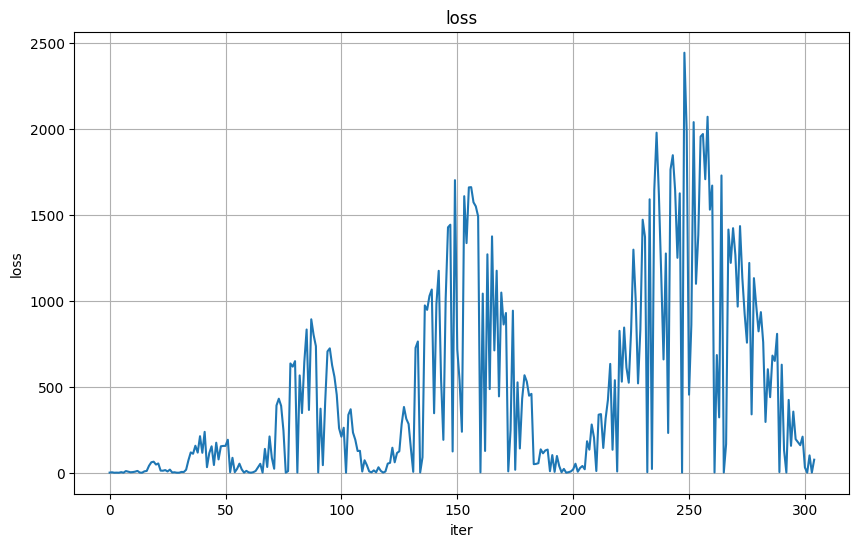

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(gru.losses)), gru.losses)#, marker='o', linestyle='-')
plt.title("loss")
plt.xlabel("iter")
plt.ylabel("loss")

plt.grid(True)
plt.show()



In [ ]:

test = valTuple[14] # random input
input = test[0]
output = test[1]
for i in range(len(input)-1):
    est1, est2 = gru.predict([input[i], input[i+1]], 2)
    gt1 = output[i].reshape(3,1)
    gt2 = output[i+1].reshape(3,1)
    diff1 = gt1 - est1
    diff2 = gt2 - est2
    print(diff1, diff2)